# Data Analysis

This notebook allows to better understand the given dataset.

**Author:** Renqing Cuomao, Rami Atassi, Paulo Ribeiro

In [1]:
import pandas as pd
from data_formatting import DataFormatting
import matplotlib.pyplot as plt 
from collections import Counter

## Load Data

In [2]:
# Raw data given for project
books_df = pd.read_csv("data/books.csv")
sample_submission_df = pd.read_csv("data/sample_submission.csv")
test_df = pd.read_csv("data/test.csv")
train_df = pd.read_csv("data/train.csv")

# Data formatted in matrix
data_formatting = DataFormatting('data/train.csv')
matrix_df = data_formatting.create_matrix_df()
matrix_np, maps = data_formatting.create_matrix_np()

### Raw Data (.csv)

In [3]:
books_df

,ISBN,book_id
0,0002005018,1
1,0374157065,3
2,0399135782,5
3,0440234743,18
4,0452264464,19
...,...,...
16594,786914041,248348
16595,62117378,247944
16596,1905294964,248214
16597,1937007588,247154


In [4]:
sample_submission_df

,id,rating
0,0,3.500829
1,1,1.276242
2,2,2.945291
3,3,3.264039
4,4,1.000000
...,...,...
29362,29362,3.409598
29363,29363,1.169232
29364,29364,3.257851
29365,29365,2.937307


In [5]:
test_df

,id,book_id,user_id
0,0,3786,40484
1,1,1985,47039
2,2,2290,60111
3,3,118657,64447
4,4,1560,2953
...,...,...,...
29362,29362,2802,12312
29363,29363,53552,25725
29364,29364,4065,77178
29365,29365,1290,23201


In [6]:
train_df

,book_id,user_id,rating
0,7260,20145,3.5
1,243238,85182,4.0
2,9135,45973,1.0
3,18671,63554,3.0
4,243293,81002,5.0
...,...,...,...
100518,15374,69658,2.0
100519,11063,69658,2.5
100520,18444,29981,1.0
100521,5917,38009,1.0


### Formatted Data

In [7]:
print(type(matrix_df), matrix_df.shape)

<class 'pandas.core.frame.DataFrame'> (18905, 15712)


In [8]:
print(type(matrix_np), matrix_np.shape)

<class 'numpy.ndarray'> (18905, 15712)


In [9]:
maps.keys()

dict_keys(['user_to_index', 'index_to_user', 'item_to_index', 'index_to_item'])

## Quick analysis

In [10]:
print(f"Number of unique books: {train_df['book_id'].unique().size}\n"
      f"Number of unique users: {train_df['user_id'].unique().size}")

Number of unique books: 15712
Number of unique users: 18905


In [11]:
print(f"Percentage of books without ISBN: {books_df['ISBN'].isna().sum() / books_df.shape[0] * 100:.2f}%")

Percentage of books without ISBN: 2.04%


In [12]:
# Distribution of number of books rated by users
train_df.groupby(by="user_id").count()['rating'].describe()

count    18905.000000
mean         5.317271
std         19.424457
min          1.000000
25%          1.000000
50%          1.000000
75%          5.000000
max       2041.000000
Name: rating, dtype: float64

In [13]:
# Distribution of number of user that have rated books
train_df.groupby(by="book_id").count()['rating'].describe()

count    15712.000000
mean         6.397849
std          9.541390
min          1.000000
25%          2.000000
50%          4.000000
75%          7.000000
max        257.000000
Name: rating, dtype: float64

In [14]:
test_user = set(test_df['user_id'].unique().tolist())
train_user = set(train_df['user_id'].unique().tolist())

if test_user.issubset(train_user):
    print(f"All clear, no test_user is unknown of train set.")
else:
    diff = (train_user ^ test_user) & test_user
    msg = " ".join([f"Following test user(s) is/are not present in train set:"] +
                   [f"\n{user}" for user in diff])
    raise ValueError(msg)

All clear, no test_user is unknown of train set.


In [15]:
#score distribution in train set
train_df['rating'].value_counts()

rating
2.0    21973
1.0    17689
1.5    15399
2.5    14177
3.0     9863
3.5     8167
4.0     6753
5.0     5577
4.5      925
Name: count, dtype: int64

In [16]:
train_df['rating'].describe()

count    100523.000000
mean          2.361738
std           1.106863
min           1.000000
25%           1.500000
50%           2.000000
75%           3.000000
max           5.000000
Name: rating, dtype: float64

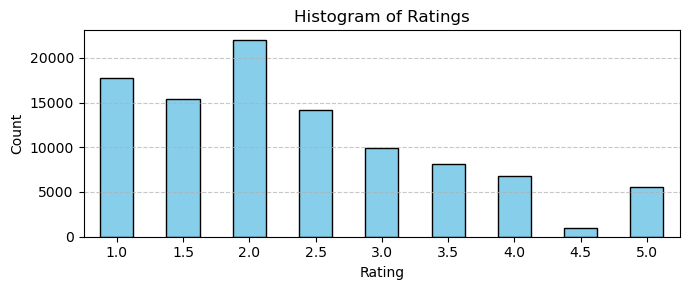

In [17]:
# Convert to a DataFrame
rating_counts_df = pd.DataFrame.from_dict(Counter(train_df['rating']), orient='index', columns=['count']).sort_index()

# Plot the histogram
plt.figure(figsize=(7, 3))
rating_counts_df['count'].plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Histogram of Ratings')
plt.xticks(ticks=range(len(rating_counts_df.index)), labels=rating_counts_df.index, rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("rating_dist.pdf")
plt.show()

Number of user with more than 3: 6062


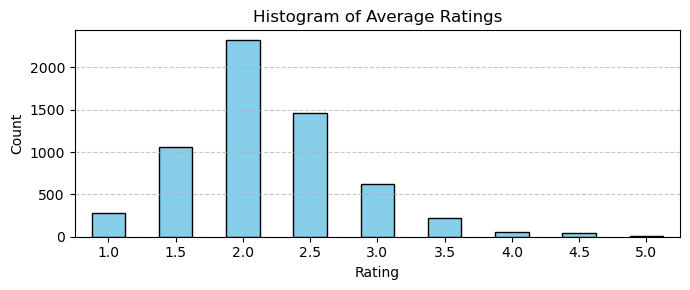

In [18]:
min_interaction = 3

# Calculate the count and mean of ratings grouped by user_id
count = train_df[['user_id', 'rating']].groupby(by='user_id').count()
mean = train_df[['user_id', 'rating']].groupby(by='user_id').mean()

# Create a DataFrame with count and mean
avg_rating_df = count.rename(columns={'rating': 'count'})
avg_rating_df['mean_rating'] = mean['rating']

# Filter users with at least 5 ratings
avg_rating_df = avg_rating_df[avg_rating_df['count'] >= min_interaction]
print(f"Number of user with more than {min_interaction}: {avg_rating_df.shape[0]}")

# Round the mean ratings to the nearest 0.5 neighbor
avg_rating_df['mean_rating_rounded'] = avg_rating_df['mean_rating'].apply(lambda x: round(x * 2) / 2)

# Convert to a DataFrame
rating_counts_df = pd.DataFrame.from_dict(Counter(avg_rating_df['mean_rating_rounded']), orient='index', columns=['count']).sort_index()

# Plot the histogram
plt.figure(figsize=(7, 3))
rating_counts_df['count'].plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Histogram of Average Ratings')
plt.xticks(ticks=range(len(rating_counts_df.index)), labels=rating_counts_df.index, rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("avg_rating.pdf")
plt.show()

In [19]:
#check the % of nan in the user item matrix
nan = matrix_df.isna().sum().sum()
total = matrix_df.shape[0] * matrix_df.shape[1]
print(f"Percentage of nan in the user item matrix: {nan / total * 100:.2f}%")

Percentage of nan in the user item matrix: 99.97%
